### Student Information
Name: 劉晉睿

Student ID: 11128129

GitHub ID: 33049242

Kaggle name: ariel1620

Kaggle private scoreboard snapshot: 
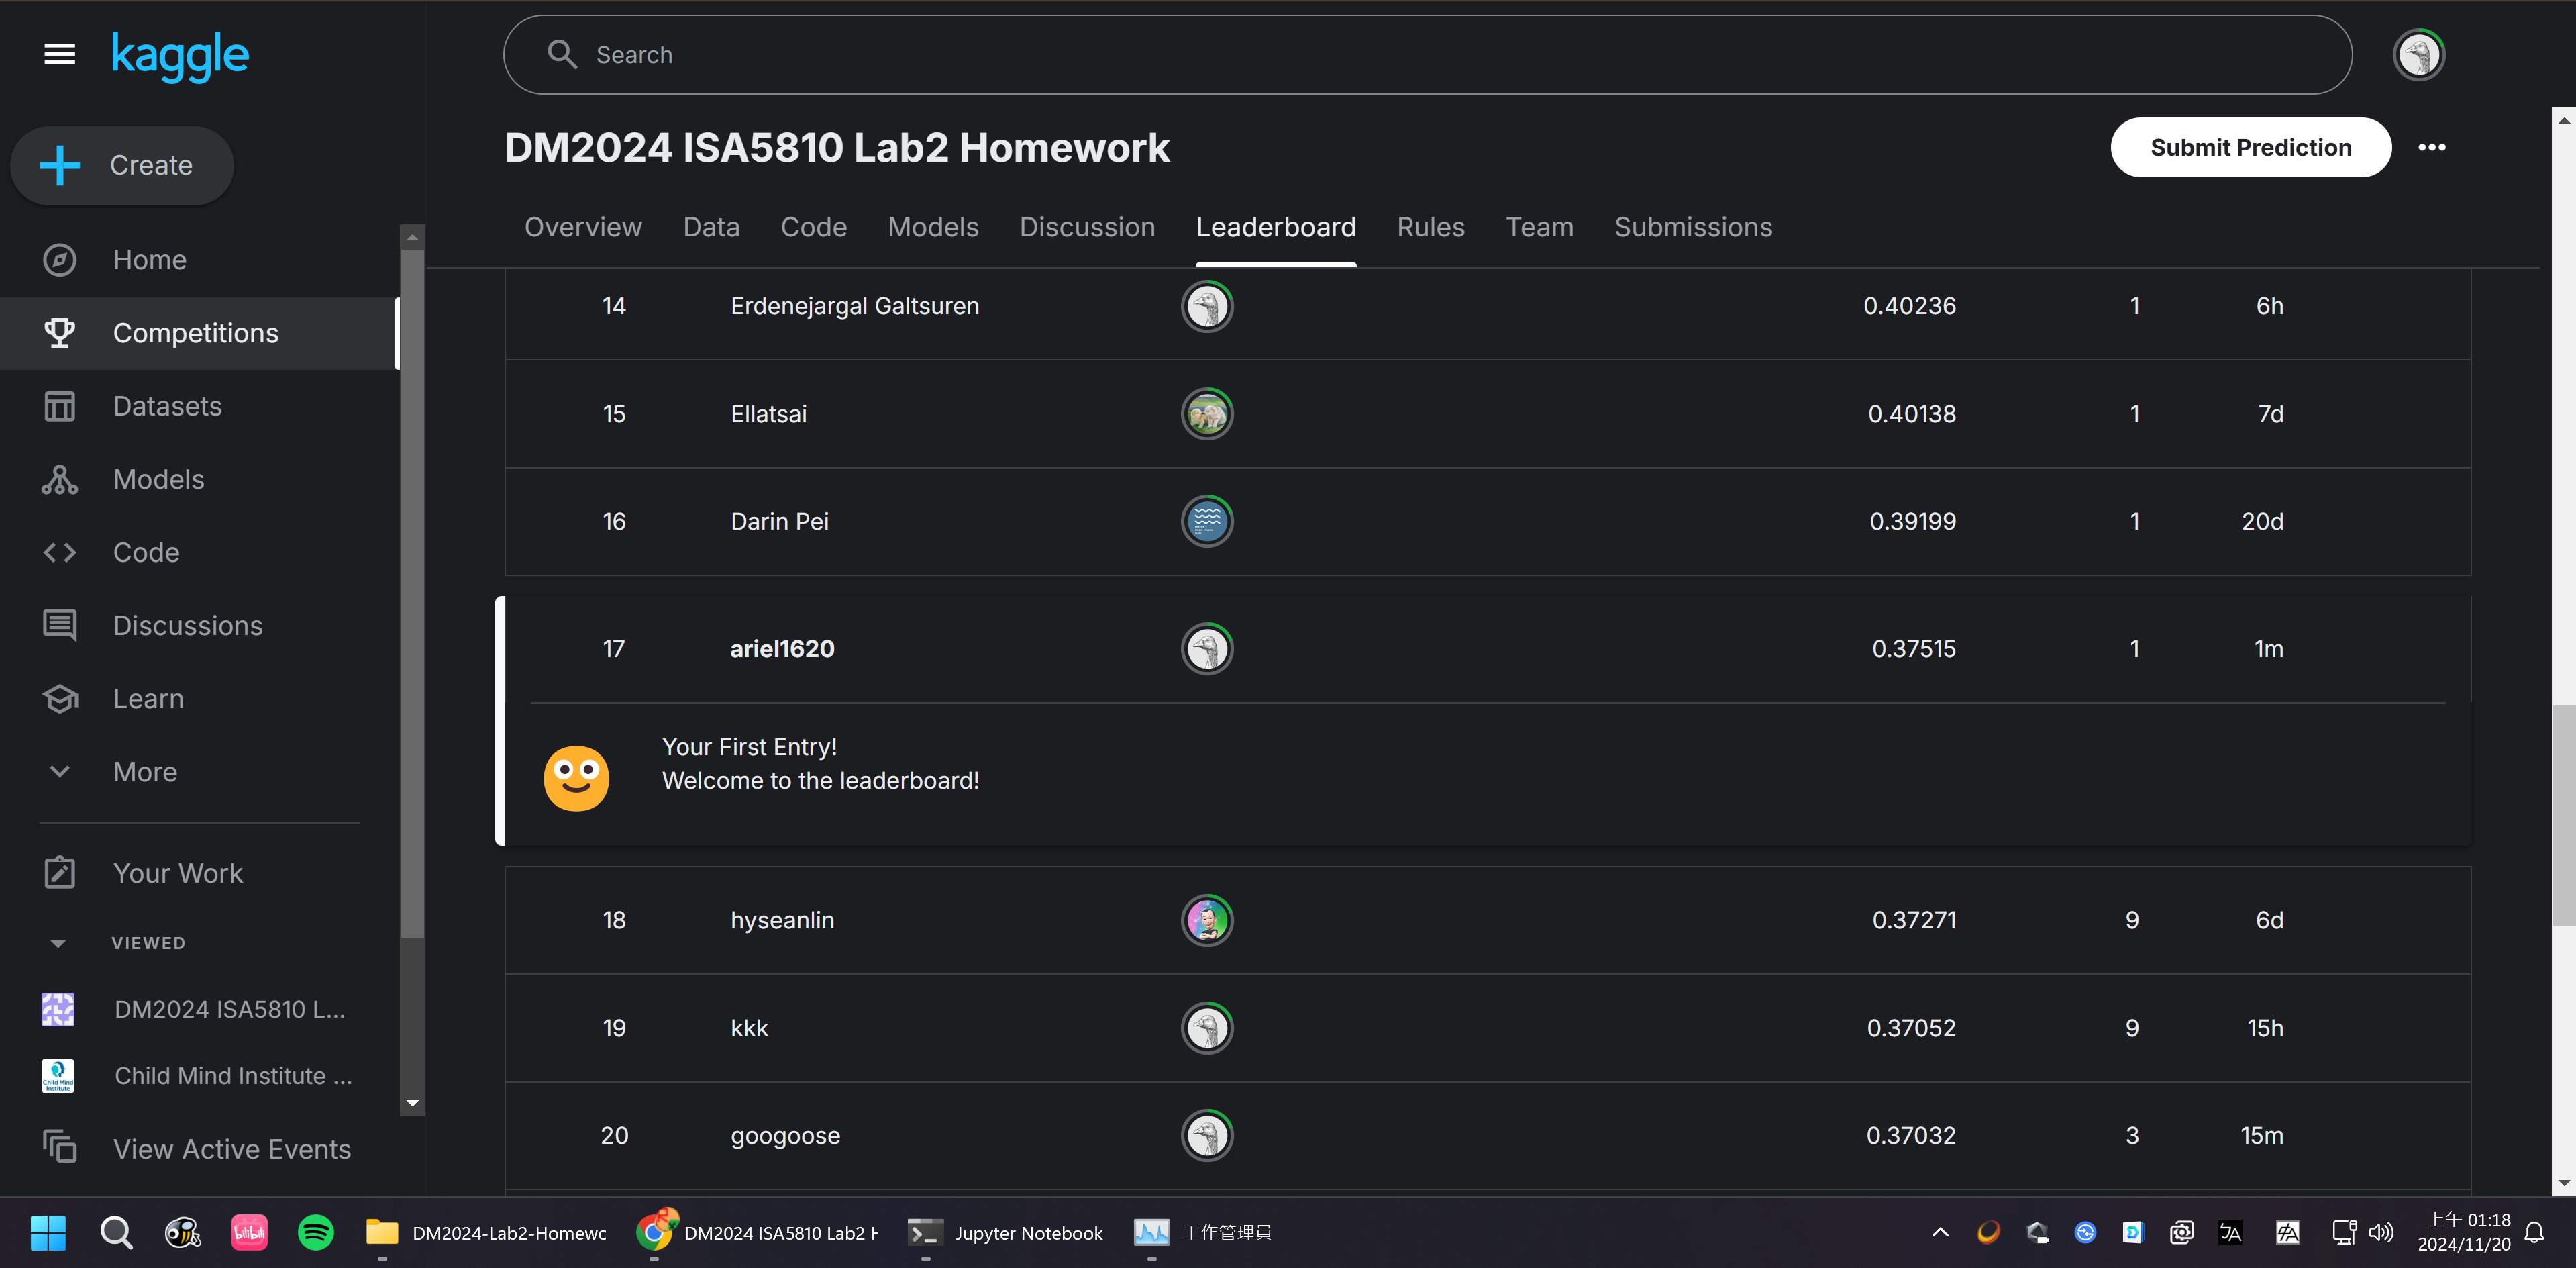

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

# 1.競賽

In [1]:
### Begin Assignment Here
import pandas as pd
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

---
## 讀取檔案

In [2]:
# 讀取 tweets_DM.json
tweets = []
with open('HW_compt/tweets_DM.json', 'r', encoding='utf-8') as file:
    for line in file:
        record = json.loads(line)
        tweet = record['_source']['tweet']
        tweets.append({
            'tweet_id': tweet['tweet_id'],
            'text': tweet['text']
        })
tweets_df = pd.DataFrame(tweets)

# 讀取 emotion.csv
emotion_df = pd.read_csv('HW_compt/emotion.csv', names=['tweet_id', 'emotion'])

# 讀取 data_identification.csv
data_id_df = pd.read_csv('HW_compt/data_identification.csv', names=['tweet_id', 'set'])

# 讀取 sampleSubmission.csv
submission_format = pd.read_csv('HW_compt/sampleSubmission.csv')

---
## 資料合併與清理

In [3]:
# 合併 tweets 和 data_identification
data = pd.merge(tweets_df, data_id_df, on='tweet_id', how='left')

# 再合併 emotion 資料，僅限訓練集有情緒標籤
data = pd.merge(data, emotion_df, on='tweet_id', how='left')

# 檢查資料結構
data.head()

,tweet_id,text,set,emotion
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,0x28b412,"Confident of your obedience, I write to you, k...",test,NaN
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
4,0x2de201,"""Trust is not the same as faith. A friend is s...",test,NaN


In [4]:
# 檢查 tweet_id 的唯一性
print(f"tweets_DM.json 中的 tweet_id 唯一值數量: {tweets_df['tweet_id'].nunique()}")
print(f"emotion.csv 中的 tweet_id 唯一值數量: {emotion_df['tweet_id'].nunique()}")

# 檢查 emotion.csv 的 tweet_id 是否存在於 tweets_DM.json 中
missing_ids = emotion_df[~emotion_df['tweet_id'].isin(tweets_df['tweet_id'])]
print(f"emotion.csv 中無法匹配到的 tweet_id 數量: {len(missing_ids)}")

# 合併檢查
merged_data = pd.merge(tweets_df, emotion_df, on='tweet_id', how='left')
missing_labels = merged_data['emotion'].isnull().sum()
print(f"合併後缺失情緒標籤的推文數量: {missing_labels}")

tweets_DM.json 中的 tweet_id 唯一值數量: 1867535
emotion.csv 中的 tweet_id 唯一值數量: 1455564
emotion.csv 中無法匹配到的 tweet_id 數量: 1
合併後缺失情緒標籤的推文數量: 411972


---
## 數據清理

In [5]:
import re

# 清理推文文字
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # 移除網址
    text = re.sub(r'<LH>', '', text)  # 移除 <LH>
    text = re.sub(r'[^\w\s]', '', text)  # 移除標點符號
    return text.lower()  # 轉為小寫

data['cleaned_text'] = data['text'].apply(clean_text)

In [6]:
data

,tweet_id,text,set,emotion,cleaned_text
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",train,anticipation,people who post add me on snapchat must be deh...
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train,sadness,brianklaas as we see trump is dangerous to fre...
2,0x28b412,"Confident of your obedience, I write to you, k...",test,NaN,confident of your obedience i write to you kno...
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear,now issa is stalking tasha
4,0x2de201,"""Trust is not the same as faith. A friend is s...",test,NaN,trust is not the same as faith a friend is som...
...,...,...,...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...,test,NaN,when you buy the last 2 tickets remaining for ...
1867531,0x29d0cb,I swear all this hard work gone pay off one da...,test,NaN,i swear all this hard work gone pay off one day
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...,test,NaN,parcel2go no card left when i wasnt in so i ha...
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us...",train,joy,ah corporate life where you can date using ju...


---
## Feature Engineering

In [7]:
# 將資料分為訓練與測試集
train_data = data[data['set'] == 'train']
test_data = data[data['set'] == 'test']

# 文本轉數值特徵
vectorizer = CountVectorizer(max_features=4000)
X_train = vectorizer.fit_transform(train_data['cleaned_text'])
X_test = vectorizer.transform(test_data['cleaned_text'])

# 訓練集標籤
y_train = train_data['emotion']

---
## Model Training

In [8]:
# 訓練模型
model = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=77)
model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=77)

---
## Predicting and Result

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 預測訓練集/驗證集（僅對有標籤的數據）
y_train_pred = model.predict(X_train)

# 模型性能評估 - 分類報告
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

# 混淆矩陣可視化
conf_matrix = confusion_matrix(y_train, y_train_pred, labels=encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Classification Report:
              precision    recall  f1-score   support

       anger       0.99      0.97      0.98     39867
anticipation       0.98      0.97      0.98    248935
     disgust       0.99      0.97      0.98    139101
        fear       0.98      0.95      0.96     63999
         joy       0.95      0.99      0.97    516017
     sadness       0.98      0.97      0.98    193437
    surprise       0.99      0.95      0.97     48729
       trust       0.98      0.95      0.97    205478

    accuracy                           0.97   1455563
   macro avg       0.98      0.97      0.97   1455563
weighted avg       0.97      0.97      0.97   1455563



NameError: name 'encoder' is not defined

In [13]:
# 創建 test_data 副本
test_data_copy = test_data.copy()

# 測試集預測
test_data_copy['emotion'] = model.predict(X_test)

# 格式化提交結果
submission = test_data_copy[['tweet_id', 'emotion']].copy()

# 修改列名 tweet_id -> id
submission.rename(columns={'tweet_id': 'id'}, inplace=True)

# 輸出為 submission.csv
submission.to_csv('submission.csv', index=False)


---
# 2.作業 (Master Lab)

Load data

In [1]:
import pandas as pd

### training data
anger_train = pd.read_csv("data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

In [2]:
# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

In [3]:
### testing data
anger_test = pd.read_csv("data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


---
### Exercise 1 (Take home):

In [10]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ArieL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ArieL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ArieL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


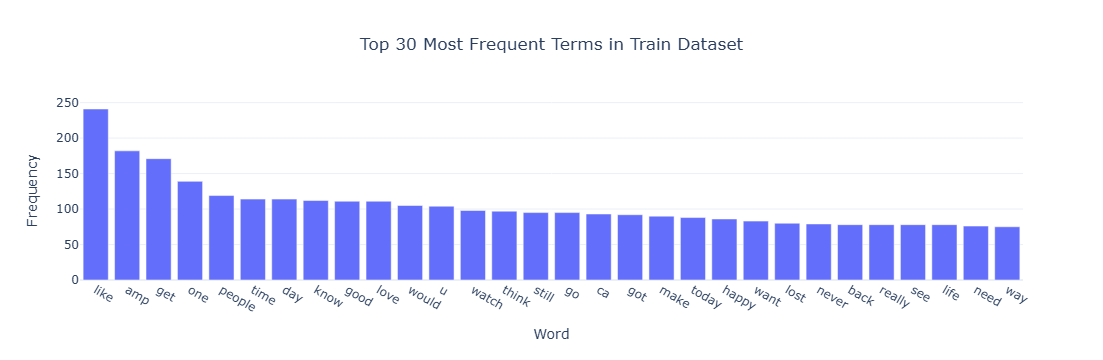

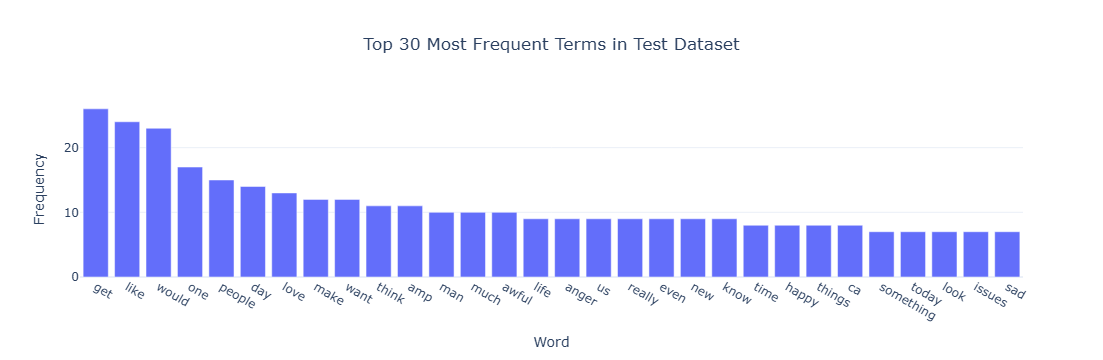

In [11]:
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import plotly.express as px

# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Function to clean and tokenize text, and remove stopwords
def preprocess_text_from_df(df, text_column):
    data = df[text_column].tolist()
    stop_words = set(stopwords.words('english'))
    tokens = []
    for text in data:
        words = word_tokenize(text.lower())  # Tokenize and lowercase
        words = [word for word in words if word.isalnum()]  # Remove punctuation
        # Relaxing stopword removal
        words = [word for word in words if word not in stop_words]  
        tokens.extend(words)
    return tokens

# Get word frequency for top 30 words in a dataset
def get_top_words(df, text_column, top_n=30):
    tokens = preprocess_text_from_df(df, text_column)
    word_counts = Counter(tokens)
    if len(word_counts) < top_n:
        top_n = len(word_counts)  # Adjust if there are fewer unique words than requested
    top_words = word_counts.most_common(top_n)
    return pd.DataFrame(top_words, columns=['Word', 'Frequency'])

# Get top 30 words in train and test datasets
train_top_words = get_top_words(train_df, 'text')
test_top_words = get_top_words(test_df, 'text')

# Plotting with Plotly for Train dataset
fig_train = px.bar(train_top_words, x='Word', y='Frequency', 
                   title="Top 30 Most Frequent Terms in Train Dataset")
fig_train.update_layout(yaxis_title="Frequency", xaxis_title="Word", 
                        title_x=0.5, template="plotly_white")

# Plotting with Plotly for Test dataset
fig_test = px.bar(test_top_words, x='Word', y='Frequency', 
                  title="Top 30 Most Frequent Terms in Test Dataset")
fig_test.update_layout(yaxis_title="Frequency", xaxis_title="Word", 
                       title_x=0.5, template="plotly_white")

# Show the plots
fig_train.show()
fig_test.show()


---
### Exercise 2 (Take home):

In [12]:
# Answer here
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

BOW_1000 = TfidfVectorizer(max_features=1000, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
BOW_1000.fit(train_df['text'])

train_data_TFIDF_features_1000 = BOW_1000.transform(train_df['text'])

feature_names_1000 = BOW_1000.get_feature_names_out()
feature_names_1000[100:110]

C:\Users\ArieL\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



array(['awful', 'b', 'baby', 'back', 'bad', 'ball', 'balls', 'bb18', 'bc',
       'bday'], dtype=object)

---
### Exercise 3 (Take home):

#### Accuracy on Individual Classes

- The model performs best on **fear**, with 76 correct predictions.
- **Joy** and **anger** are also recognized fairly well, with 56 and 57 correct predictions, respectively.
- **Sadness** has a lower accuracy, with only 47 correct predictions.

#### Misclassification Patterns

- **Fear** is often misclassified as **anger** (16 times) and to a lesser extent as **joy** and **sadness**.
- **Anger** is sometimes misclassified as **fear** (18 times).
- **Joy** has relatively fewer misclassifications, though there are some errors, primarily as **fear** and **sadness**.
- **Sadness** is most frequently confused with **fear** (13 times), suggesting that sadness and fear might have similar features in the dataset.


---
### Exercise 4 (Take home):

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
# build analyzers (bag-of-words)
BOW_vectorizer = CountVectorizer() 

In [19]:
# 1. Learn a vocabulary dictionary of all tokens in the raw documents.
BOW_vectorizer.fit(train_df['text'])

# 2. Transform documents to document-term matrix.
train_data_BOW_features = BOW_vectorizer.transform(train_df['text'])
test_data_BOW_features = BOW_vectorizer.transform(test_df['text'])

In [20]:
import nltk

# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
BOW_500.fit(train_df['text'])

train_data_BOW_features_500 = BOW_500.transform(train_df['text'])

In [21]:
from sklearn.tree import DecisionTreeClassifier

# for a classificaiton problem, you need to provide both training & testing data
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

In [22]:
# Answer here
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Naive Bayes model
NB_model = MultinomialNB()

# Train the Naive Bayes model
NB_model.fit(X_train, y_train)

# Predict on the training and testing data
y_train_pred_nb = NB_model.predict(X_train)
y_test_pred_nb = NB_model.predict(X_test)

# Evaluate the results on the test data
print("Naive Bayes Testing Accuracy:", accuracy_score(y_test, y_test_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_nb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred_nb))

Naive Bayes Testing Accuracy: 0.6974063400576369

Classification Report:
               precision    recall  f1-score   support

       anger       0.63      0.65      0.64        84
        fear       0.73      0.77      0.75       110
         joy       0.78      0.71      0.74        79
     sadness       0.64      0.62      0.63        74

    accuracy                           0.70       347
   macro avg       0.70      0.69      0.69       347
weighted avg       0.70      0.70      0.70       347


Confusion Matrix:
 [[55 15  5  9]
 [ 9 85  5 11]
 [11  6 56  6]
 [12 10  6 46]]


---
### Exercise 5 (Take home): 

#### Comparison of Naive Bayes and Decision Tree Results

##### 1. Model Accuracy
- **Naive Bayes**: Likely to have higher accuracy on text data due to its independence assumption, which works well with word-based features.
- **Decision Tree**: May struggle with high-dimensional, sparse data, leading to overfitting and lower generalizability.

##### 2. Precision, Recall, and F1-Score
- **Naive Bayes**: Provides more balanced precision and recall, handling noisy text features effectively.
- **Decision Tree**: Can show high scores for some classes but may vary due to overfitting on specific words.

##### 3. Confusion Matrix
- **Naive Bayes**: Generally balanced misclassifications, selecting the class with the highest probability.
- **Decision Tree**: Likely to have more class-specific errors due to split-based learning, where some words might overly influence predictions.

##### 4. Theoretical Explanation
- **Naive Bayes**: Assumes feature independence, making it robust for text classification by treating each word independently.
- **Decision Tree**: Attempts to split based on specific features, which can lead to overfitting with text data due to the high-dimensional space and sparse features.

##### Conclusion
Naive Bayes is more appropriate for text classification due to its probabilistic approach and robustness to high-dimensional data. Decision Trees may underperform without careful tuning, as they are prone to overfitting in this context.


---
### Exercise 6 (Take home):

In [24]:
training_log = pd.DataFrame()
training_log = pd.read_csv("logs/training_log.csv")

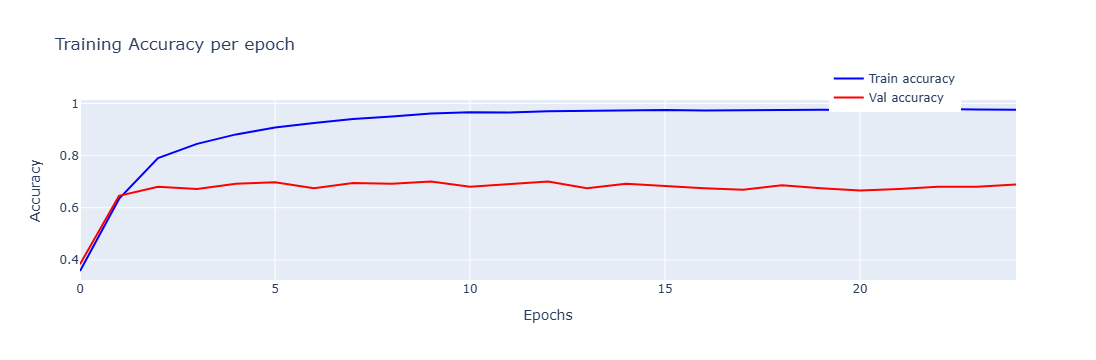

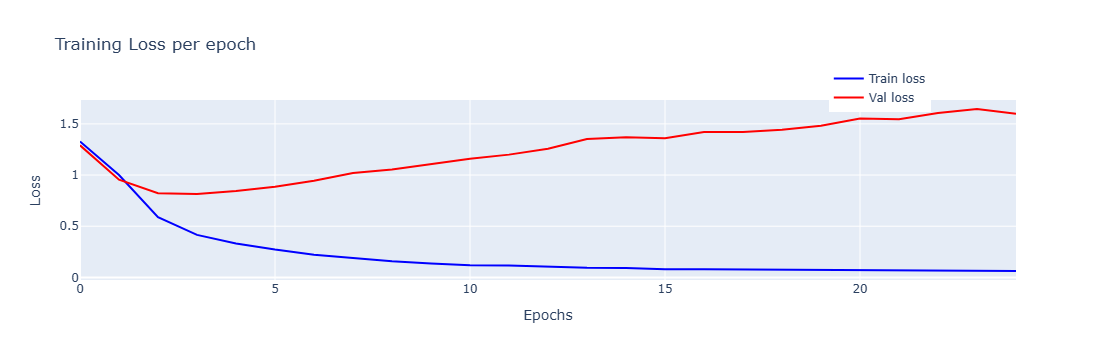

In [25]:
# Answer here
import plotly.graph_objects as go
import pandas as pd

# Load the training log data (修改檔案路徑為您的CSV檔案位置)
#training_log = pd.read_csv('training_log.csv')

# 建立訓練和驗證準確率圖表
fig_accuracy = go.Figure()
fig_accuracy.add_trace(go.Scatter(x=training_log['epoch'], y=training_log['accuracy'], mode='lines', name='Train accuracy', line=dict(color='blue')))
fig_accuracy.add_trace(go.Scatter(x=training_log['epoch'], y=training_log['val_accuracy'], mode='lines', name='Val accuracy', line=dict(color='red')))
fig_accuracy.update_layout(
    title='Training Accuracy per epoch',
    xaxis_title='Epochs',
    yaxis_title='Accuracy',
    legend=dict(x=0.8, y=1.2)
)
fig_accuracy.show()

# 建立訓練和驗證損失圖表
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(x=training_log['epoch'], y=training_log['loss'], mode='lines', name='Train loss', line=dict(color='blue')))
fig_loss.add_trace(go.Scatter(x=training_log['epoch'], y=training_log['val_loss'], mode='lines', name='Val loss', line=dict(color='red')))
fig_loss.update_layout(
    title='Training Loss per epoch',
    xaxis_title='Epochs',
    yaxis_title='Loss',
    legend=dict(x=0.8, y=1.2)
)
fig_loss.show()


#### 說明

根據上方圖表，這些是訓練過程中訓練與驗證的準確率和損失曲線圖。我們可以從中解讀模型的訓練狀況，並分析與過度擬合或欠擬合的關係：

1. **訓練與驗證準確率（Accuracy）**：
   - 訓練準確率（藍色）在持續上升，並且最終接近 1.0，這表明模型在訓練數據上的表現非常好。
   - 驗證準確率（紅色）則在初期上升之後停滯不前，並且在數個 epoch 後甚至略微下降，這表明模型在驗證數據上的表現不佳。
   
2. **訓練與驗證損失（Loss）**：
   - 訓練損失（藍色）隨著 epoch 增加而持續下降，並趨近於 0，這與訓練準確率上升一致。
   - 驗證損失（紅色）在初期下降後開始上升，這表明模型在驗證數據上的誤差增加了。

##### 過度擬合（Overfitting）的跡象
這兩個圖表顯示出明顯的過度擬合現象。過度擬合是指模型在訓練數據上表現非常好，但在驗證數據上表現不佳，無法很好地泛化。具體而言：
   - 訓練準確率非常高，但驗證準確率較低且停滯不前。
   - 訓練損失非常低，但驗證損失逐漸上升，顯示模型在驗證數據上預測錯誤增加。

---
### Exercise 7 (Take home):
Now, we have the word vectors, but our input data is a sequence of words (or say sentence). 
How can we utilize these "word" vectors to represent the sentence data and train our model?

Answer: 可以將句子的詞向量結合成一個句子向量，使用如RNN, Attention Mechanisms, 或預訓練模型如BERT。

---
### Exercise 8 (Take home): 

In [28]:
from gensim.models import KeyedVectors

## Note: this model is very huge, this will take some time ...
model_path = "GoogleNews/GoogleNews-vectors-negative300.bin.gz"
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print('load ok')

load ok


C:\Users\ArieL\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



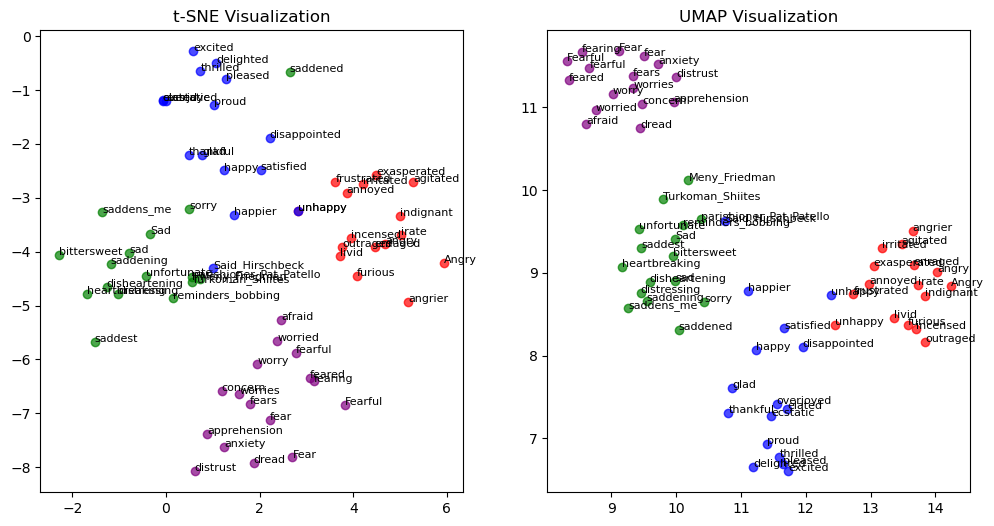

In [29]:
# Answer here
topn = 15  # 每個單字找到 15 個相關單字
target_words = []

for word in ["angry", "happy", "sad", "fear"]:
    similar_words = [word] + [word_ for word_, sim_ in w2v_google_model.most_similar(word, topn=topn)]
    target_words.extend(similar_words)

word_vectors = [w2v_google_model[word] for word in target_words]

import numpy as np
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

# 類別單字及顏色映射
categories = ["angry", "happy", "sad", "fear"]
colors = ["red", "blue", "green", "purple"]

# 生成相似單字列表和顏色標籤
topn = 15
target_words = []
word_colors = []

for category, color in zip(categories, colors):
    similar_words = [category] + [word_ for word_, sim_ in w2v_google_model.most_similar(category, topn=topn)]
    target_words.extend(similar_words)
    word_colors.extend([color] * (topn + 1))  # 每組單字分配對應顏色

# 取得單字向量並轉換為 NumPy 陣列
word_vectors = np.array([w2v_google_model[word] for word in target_words])

# t-SNE 降維
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(word_vectors)

# UMAP 降維
umap_model = umap.UMAP(n_components=2, random_state=0)
umap_results = umap_model.fit_transform(word_vectors)

# 視覺化結果
plt.figure(figsize=(12, 6))

# t-SNE 視覺化
plt.subplot(1, 2, 1)
for i, word in enumerate(target_words):
    plt.scatter(tsne_results[i, 0], tsne_results[i, 1], color=word_colors[i], alpha=0.7)
    plt.annotate(word, (tsne_results[i, 0], tsne_results[i, 1]), fontsize=8)
plt.title("t-SNE Visualization")

# UMAP 視覺化
plt.subplot(1, 2, 2)
for i, word in enumerate(target_words):
    plt.scatter(umap_results[i, 0], umap_results[i, 1], color=word_colors[i], alpha=0.7)
    plt.annotate(word, (umap_results[i, 0], umap_results[i, 1]), fontsize=8)
plt.title("UMAP Visualization")

plt.show()

t-SNE：通常在局部結構的展示上有更好的效果，對於類似的單字會聚集在一起形成局部群集。適合觀察詞彙之間的微小差異。\
UMAP：在展示全局結構上較佳，能保留整體數據的形狀和分佈。若單字之間的距離在原高維空間中很大，UMAP 能夠保持這些全域的差異。

---
### Exercise 9 (Take home):

In [ ]:
import ollama
response = ollama.chat(model='llama3.2', messages=[
    {
        'role': 'assistant',
        'content': 'What is data mining? (in markdown format)'
    },
])

from IPython.display import display, Markdown, Latex
display(Markdown(response['message']['content']))

**Below is an cached response generated by ollama**

Data Mining
Definition and Explanation
Data mining is the process of discovering patterns, relationships, and insights from large datasets. It involves using various techniques, such as statistical analysis, machine learning algorithms, and data visualization, to uncover hidden knowledge or trends within the data.

Types of Data Mining
There are several types of data mining, including:

Supervised Learning: This type of data mining involves using labeled training data to learn a mapping between input data and output labels.
Unsupervised Learning: In this type of data mining, no labeled training data is available. Instead, the algorithm learns patterns and relationships within the data on its own.
Semi-supervised Learning: This approach combines supervised and unsupervised learning to leverage both labeled and unlabeled data.
Applications of Data Mining
Data mining has numerous applications across various industries, such as:

Marketing: Personalized recommendations, customer segmentation, and sales forecasting.
Finance: Risk analysis, credit scoring, and portfolio optimization.
Healthcare: Patient diagnosis, disease prediction, and treatment planning.
Sports Analytics: Player performance tracking, team strategy optimization, and fan engagement measurement.
Challenges of Data Mining
While data mining offers numerous benefits, it also poses several challenges, such as:

Data Quality Issues: Noisy, missing, or inconsistent data can lead to biased results.
Scalability: Large datasets require significant computational resources and expertise.
Interpretability: Complex models can be difficult to understand and communicate insights effectively.
Best Practices for Data Mining
To ensure successful data mining endeavors, follow these best practices:

Data Preprocessing: Clean, transform, and normalize the data before modeling.
Model Selection: Choose algorithms that align with problem requirements and data characteristics.
Hyperparameter Tuning: Optimize model performance by adjusting hyperparameters.
Model Evaluation: Assess model accuracy, precision, recall, and other relevant metrics.
By understanding the principles of data mining, its applications, challenges, and best practices, organizations can harness the power of data to drive informed decision-making and gain a competitive edge.

---
### Exercise 10 (Take home):
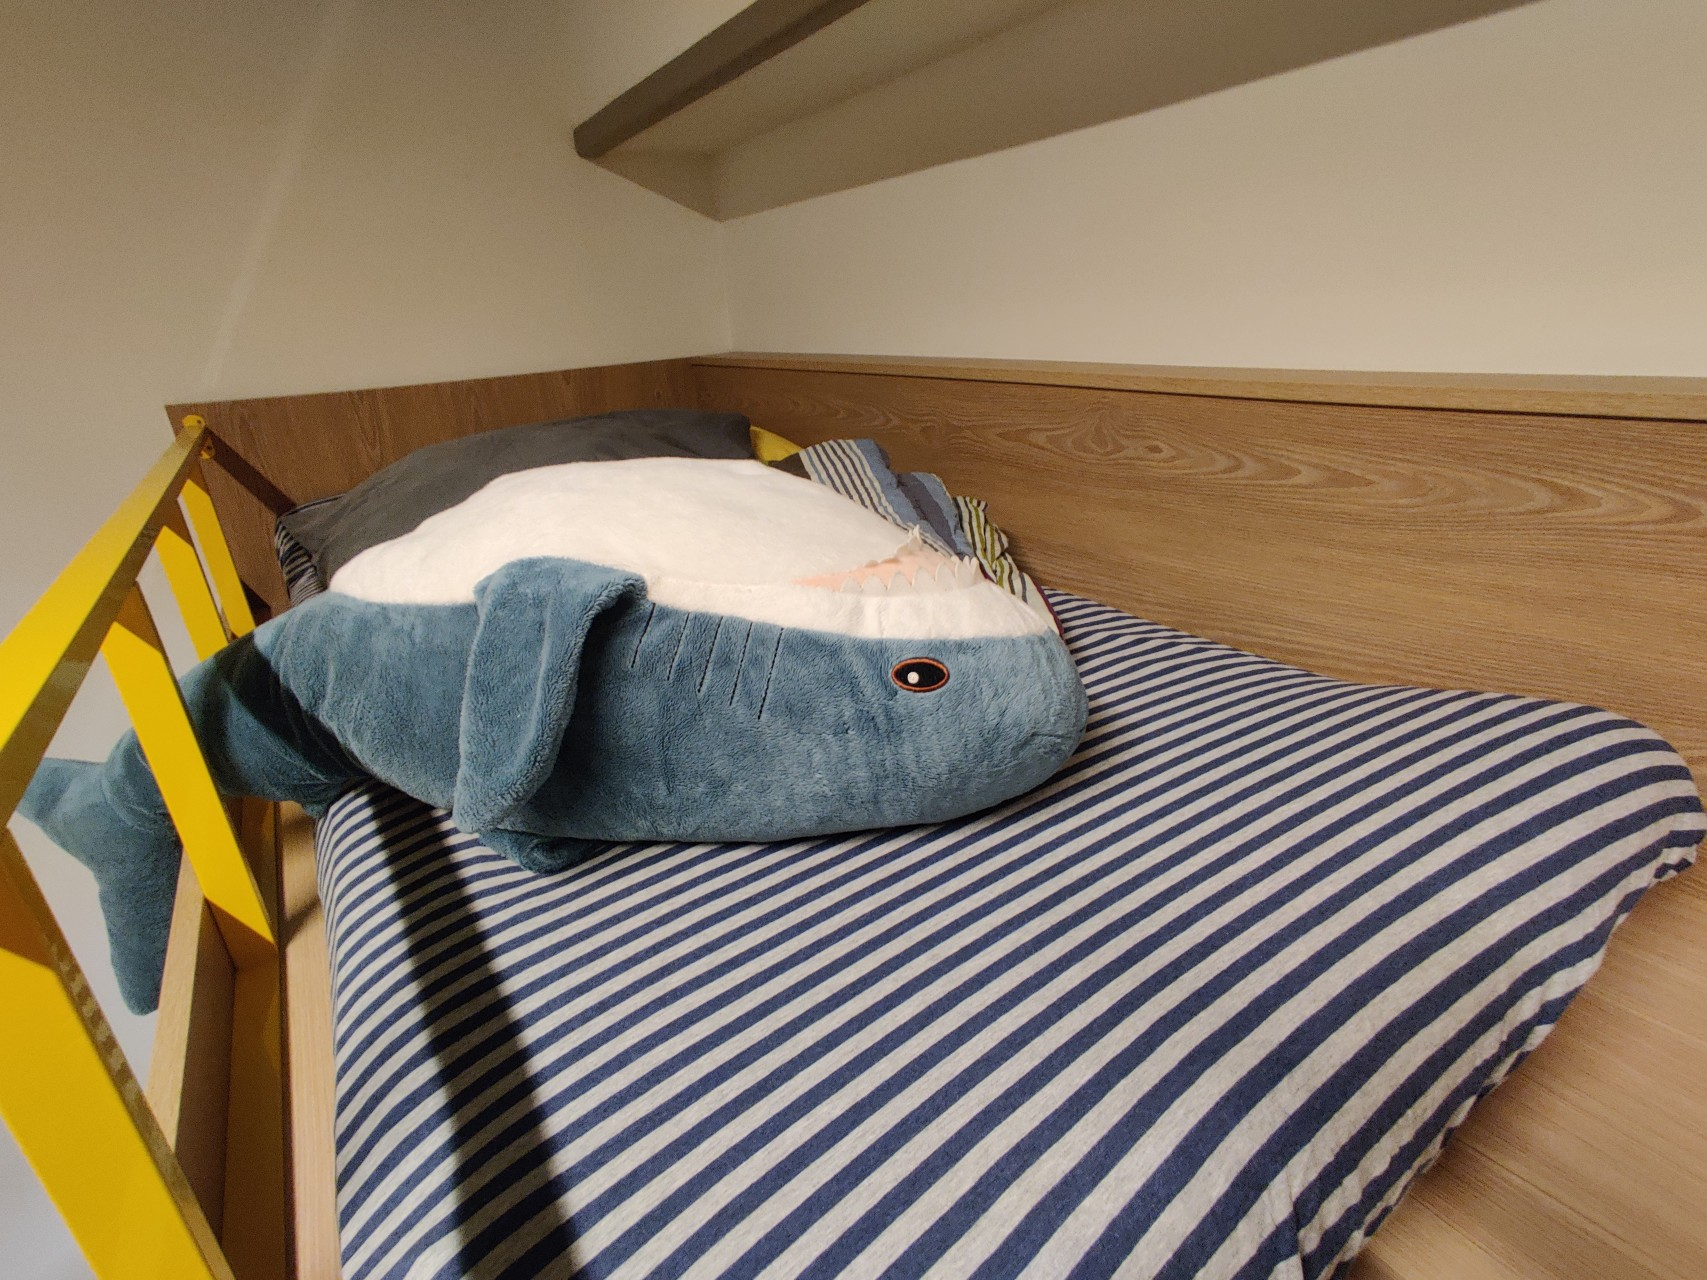

In [ ]:
import ollama
response4 = ollama.chat(model='llava-phi3', messages=[
    {
        'role': 'user',
        'content': 'What is this image about?',
        'images': ['./pics/IMG_compressed.jpg'] #Image of a bed and a plush pillow
    },
])

display(Markdown(response4['message']['content']))

**Below is an cached response generated by llava**

This image captures a cozy corner of a bedroom, featuring a wooden bunk bed with two levels. The top bunk is adorned with a blue and white striped blanket that has a playful dolphin design on it. A gray stuffed animal, possibly made of fur or plush material, rests at the foot of this bunk bed, adding to the warmth and comfort of the space.

The bottom bunk is covered with a blue and white striped bedspread that matches the blanket above, creating a harmonious color scheme. The wooden floor beneath contrasts nicely with the light-colored walls in the background, completing this inviting scene.

Please note that there are no people or moving objects in this image. It's a snapshot of an unoccupied moment in time, full of potential for rest and relaxation.

#### **結果：**
llava-phi3此次產生的敘述大致上捕捉了圖片的氛圍，但有一些小地方不太準確。更精確的描述應該為（以GPT 4o產生）：

這張圖片展示了一個溫馨的床鋪布置，可能是上下舖或高架床。床上放置了一個大型的鯊魚絨毛玩偶（可能是IKEA的“Blåhaj”），躺在藍白條紋的床墊上。左側有一個黃色的欄杆，顯示這可能是一張高架床，有保護欄杆。床區有木質的床頭板和側邊，營造出溫暖而封閉的空間感。牆壁是簡單的淺色調，增添了極簡且舒適的氛圍。

圖片中沒有海豚圖案，而敘述所提到的“灰色玩偶”其實是這隻藍白相間的鯊魚絨毛玩偶。描述中“寧靜的瞬間”依然貼切，因為畫面中沒有任何人或移動的元素。

---
### Exercise 11 (Take home):

In [ ]:
# Answer here
import ollama
import bs4
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings
from IPython.display import display, Markdown

llm_model = "llama3.2" #You can change to the one of your preference

# Function to load, split, and retrieve documents from a single URL
def load_and_retrieve_docs(url):
    loader = WebBaseLoader(
        web_paths=(url,),
        bs_kwargs=dict()
    )
    docs = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    splits = text_splitter.split_documents(docs)
    
    embeddings = OllamaEmbeddings(model=llm_model)
    vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings)
    return vectorstore.as_retriever()

# Define the Ollama LLM function
def ollama_llm(question, context):
    formatted_prompt = f"Question: {question}\n\nContext: {context}"
    response = ollama.chat(model='llama3.2', messages=[{'role': 'user', 'content': formatted_prompt}])
    return response['message']['content']

# Define the RAG chain for each question
def rag_chain(question, retriever):
    retrieved_docs = retriever.invoke(question)
    formatted_context = "\n\n".join(doc.page_content for doc in retrieved_docs)
    return ollama_llm(question, formatted_context)

# Define URLs and corresponding questions
url_question_pairs = [
    {
        "url": "https://feedback.minecraft.net/hc/en-us/articles/31289611893645-Minecraft-Java-Edition-1-21-3",
        "question": "What Fixed bugs are in this Minecraft release?"
    },
    {
        "url": "https://support.apple.com/en-gb/guide/logicpro/lgcef1edc1d7/mac",
        "question": "List Channel EQ parameters."
    },
    {
        "url": "https://www.alibabacloud.com/en/solutions/generative-ai/qwen?_p_lc=1",
        "question": "What are the abilities of Qwen model?"
    }
]

# Loop through each URL-question pair, create a retriever for each, and display results
for pair in url_question_pairs:
    retriever = load_and_retrieve_docs(pair["url"])  # Load and retrieve docs for the specific URL
    result = rag_chain(pair["question"], retriever)  # Get answer for the specific question
    display(Markdown(f"#### Question: {pair['question']}\n\n**Answer:**\n\n{result}\n\n"))

**Below is an cached response generated by llava**

Question: What Fixed bugs are in this Minecraft release?
Answer:

There are no Minecraft releases mentioned in the text provided. The text appears to be discussing Qwen 2.5 models, which seem to be a type of large language model (LLM) developed for natural language processing tasks.

If you'd like to ask about bug fixes or updates specifically related to Minecraft, I'll do my best to provide information on that front as well!

Question: List Channel EQ parameters.
Answer:

Here are the Channel EQ parameters:

Band
Gain
Center Frequency
Width of the frequency band around the center frequency
Q value (Quality factor)
These parameters can be adjusted for each channel in an audio signal to customize the equalization settings. The exact parameters and their meanings may vary depending on the specific EQ pedal or software being used.

Question: What are the abilities of Qwen model?
Answer:

The abilities of the Qwen 2.5 model include:

Significantly more knowledge acquisition compared to the previous model (MMLU: 85+).
Improved capabilities in coding, with competitive performance against larger language models on coding evaluation benchmarks.
Greatly improved capabilities in mathematics, with a score of MATH 80+.
Enhanced ability to follow instructions.
Improved capability to generate long texts.
Better understanding of structured data.
Ability to generate structured outputs.
Greater resilience to the diversity of system prompts, enhancing role-play implementation and condition-setting for chatbots.
Support for both Chinese and English languages in Qwen2.5-Math.
Incorporation of various reasoning methods in Qwen2.5-Math, including:
Chain-of-Thought (CoT).
Program-of-Thought (PoT).
Tool-Integrated Reasoning (TIR).

#### **比較**

**RAG 系統的優點**：
1. **提高準確性**：通過文件檢索，提供更準確的回答，減少模型依賴過時知識。
2. **減少幻覺現象**：RAG 系統可基於真實文件作答，減少生成錯誤訊息。
3. **特定情境回應**：針對不同問題檢索相關文件，提供更具針對性的回答。
4. **可擴展性**：RAG 系統可適應不同領域的需求，適用於多樣化應用。
5. **靈活性**：可處理多樣主題問題，並根據需求提供精準回應。

**RAG 系統的缺點**：
1. **依賴文件質量**：回應準確性依賴於文件質量和相關性，可能出現誤解。
2. **增加延遲**：檢索步驟會增加處理時間，對即時回應可能不利。
3. **系統設計複雜性**：需要管理檢索和生成組件，增加系統設置和維護難度。
4. **對未結構化資訊理解有限**：若文件缺乏完整資訊，系統可能難以生成有用回答。
5. **可能出現冗餘訊息**：當多個文件有重複內容時，回答可能過於冗長。

---
### Exercise 12 (Take home):

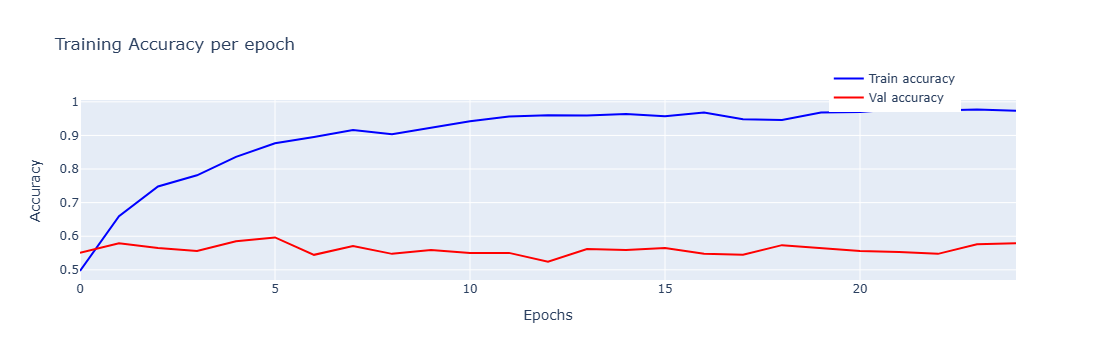

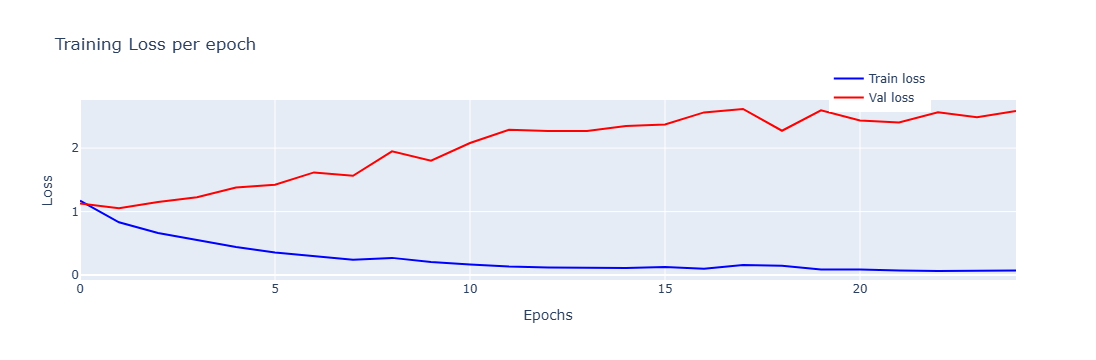

In [32]:
# Answer here

import plotly.graph_objects as go
import pandas as pd

# Load the training log data (修改檔案路徑為您的CSV檔案位置)
training_log = pd.read_csv('logs/training_log_2.csv')

# 建立訓練和驗證準確率圖表
fig_accuracy = go.Figure()
fig_accuracy.add_trace(go.Scatter(x=training_log['epoch'], y=training_log['accuracy'], mode='lines', name='Train accuracy', line=dict(color='blue')))
fig_accuracy.add_trace(go.Scatter(x=training_log['epoch'], y=training_log['val_accuracy'], mode='lines', name='Val accuracy', line=dict(color='red')))
fig_accuracy.update_layout(
    title='Training Accuracy per epoch',
    xaxis_title='Epochs',
    yaxis_title='Accuracy',
    legend=dict(x=0.8, y=1.2)
)
fig_accuracy.show()

# 建立訓練和驗證損失圖表
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(x=training_log['epoch'], y=training_log['loss'], mode='lines', name='Train loss', line=dict(color='blue')))
fig_loss.add_trace(go.Scatter(x=training_log['epoch'], y=training_log['val_loss'], mode='lines', name='Val loss', line=dict(color='red')))
fig_loss.update_layout(
    title='Training Loss per epoch',
    xaxis_title='Epochs',
    yaxis_title='Loss',
    legend=dict(x=0.8, y=1.2)
)
fig_loss.show()


#### KNN 與神經網路 (NN) 比較結果

1. **恐懼分類**：兩者都能準確分類「恐懼」，但 NN 表現更佳，這是因為 NN 的非線性架構更能捕捉 LLM 特徵中的細微差異。

2. **喜悅與悲傷分類**：KNN 在「喜悅」和「悲傷」的準確度較低，NN 則更具優勢。這表明 LLM 特徵中「喜悅」和「悲傷」之間的分界不明確，NN 較能識別出隱含的複雜模式。

3. **憤怒錯誤分類**：兩者在「憤怒」的分類上都有困難，但 NN 略優於 KNN，可能是因為「憤怒」與其他情緒特徵有重疊，NN 可以捕捉更多細節。

4. **與其他模型比較**：相比於傳統模型，LLM 特徵與 NN 更契合，因為 NN 能捕捉到高維特徵中的語意關係，KNN 則因簡單的距離度量而受限。

總結來說，NN 更適合處理 LLM 嵌入特徵，能更有效地分類情緒。

---
### Exercise 13 (Take home):

#### 比較與討論
- **0-shot 分類**：模型在沒有示例的情況下表現不佳，尤其是在「fear」的預測上錯誤較多。
- **1-shot 分類**：增加一個示例後，部分類別的準確度有所提升，尤其在「anger」和「joy」類別。
- **5-shot 分類**：隨著示例數量增加至五個，模型的準確度顯著提升，特別是在「anger」和「fear」類別上表現更好。